In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
import numpy as np
import pandas as pd
import shutil
import time
import cv2 as cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
from IPython.core.display import display, HTML

(511, 511, 4)


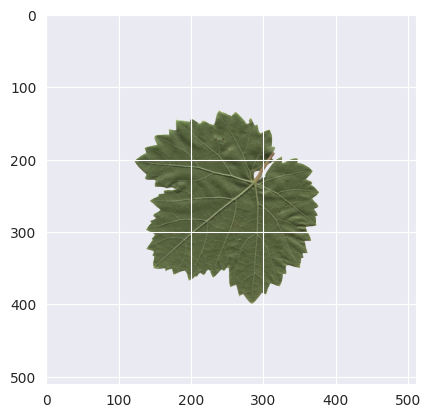

In [3]:
fpath=r'/content/drive/MyDrive/UZUM YAPRAK VERISETI/Ak/Ak (10).png'
img=plt.imread(fpath)
print (img.shape)
imshow(img)

In [4]:
sdir=r'/content/drive/MyDrive/UZUM YAPRAK VERISETI'
working_dir=r'./'
s_dir=os.path.join(working_dir, 'UZUM YAPRAK VERISETI')
if os.path.isdir(s_dir):
    shutil.rmtree(s_dir)
shutil.copytree(sdir, s_dir)
sdir = s_dir
classlist=os.listdir(sdir)    
filepaths=[]
labels=[]    
for sinif in classlist:
    if sinif != 'nonsegmentedimage':
        classpath=os.path.join(sdir,sinif)
        if os.path.isdir(classpath):
            flist=os.listdir(classpath)        
            for f in flist:
                fpath=os.path.join(classpath,f)        
                filepaths.append(fpath)
                labels.append(sinif)
Fseries=pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')    
df=pd.concat([Fseries, Lseries], axis=1)    
print('df length: ', len(df))
print (df['labels'].value_counts())

df length:  500
Dimnit       100
Buzgulu      100
Ala_Idris    100
Ak           100
Nazli        100
Name: labels, dtype: int64


In [5]:
train_split=.9
test_split=.1
train_df, test_df=train_test_split(df, train_size=train_split, shuffle=True, random_state=123)
print ('train_df length: ', len(train_df),'  test_df length: ', len(test_df))

working_dir=r'./'
test_dir=os.path.join(working_dir, 'test')
if os.path.isdir(test_dir):
    shutil.rmtree(test_dir)
os.mkdir(test_dir)
for label in df['labels'].unique():
    dir_path=os.path.join(test_dir,label)    
    os.mkdir(dir_path)
print(os.listdir(test_dir))

for f in test_df['filepaths']:
    shutil.move(f,test_dir + f[32:])
    test_df = test_df.replace(to_replace = f, value = test_dir + f[32:])

train_df length:  450   test_df length:  50
['Dimnit', 'Buzgulu', 'Ala_Idris', 'Ak', 'Nazli']


In [6]:
filepaths=[]
labels=[]    
for sinif in classlist:
    if sinif != 'nonsegmentedimage':
        classpath=os.path.join(sdir,sinif)
        if os.path.isdir(classpath):
            flist=os.listdir(classpath)        
            for f in flist:
                fpath=os.path.join(classpath,f)        
                filepaths.append(fpath)
                labels.append(sinif)
Fseries=pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')    
df=pd.concat([Fseries, Lseries], axis=1)    
print('df length: ', len(df))
print (df['labels'].value_counts())

df length:  450
Buzgulu      93
Nazli        93
Ak           89
Ala_Idris    88
Dimnit       87
Name: labels, dtype: int64


In [8]:
train_split=0.9
valid_split=0.1
train_df, valid_df=train_test_split(train_df, train_size=train_split, shuffle=True, random_state=123)
print ('train_df length: ', len(train_df),'  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))

train_df length:  364   test_df length:  50   valid_df length:  41


In [9]:
height=66
width=66
channels=3
batch_size=40
img_shape=(height, width, channels)
img_size=(height, width)
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps=int(length/test_batch_size)
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps)
train_gen=ImageDataGenerator().flow_from_dataframe( train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
test_gen=ImageDataGenerator().flow_from_dataframe( test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=test_batch_size)
valid_gen=ImageDataGenerator().flow_from_dataframe( valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)

test batch size:  50   test steps:  1
Found 364 validated image filenames belonging to 5 classes.
Found 50 validated image filenames belonging to 5 classes.
Found 41 validated image filenames belonging to 5 classes.


In [10]:
def print_in_color(txt_msg,fore_tupple,back_tupple,):
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m' 
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True)
    return

In [11]:
model_name='VGG19'
basemodel = tf.keras.applications.DenseNet121(weights = "imagenet",input_shape = img_shape,include_top=False,pooling='max')
x=basemodel.output
x=keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.45, seed=123)(x)        
output = Dense(5, activation="softmax")(x)
model = tf.keras.Model(inputs = basemodel.inputs, outputs = output)
model.compile(Adamax(lr=.001), loss='categorical_crossentropy', metrics=['accuracy']) 
model.summary()

29084464/29084464 [==============================] - 0s 0us/step


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 66, 66, 3)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 72, 72, 3)   0           ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 33, 33, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 33, 33, 64)   256         ['conv1/conv[0][0]']             
                                                                                              

In [12]:
class LRA(keras.callbacks.Callback):
    reset=False
    count=0
    stop_count=0
    
    def __init__(self,model, patience,stop_patience, threshold, factor, dwell, model_name, freeze,batches, initial_epoch,epochs, ask_epoch):
        super(LRA, self).__init__()
        self.epochs=epochs
        self.ask_epoch=ask_epoch
        self.model=model
        self.patience=patience 
        self.stop_patience=stop_patience
        self.threshold=threshold 
        self.factor=factor 
        self.dwell=dwell
        self.lr=float(tf.keras.backend.get_value(model.optimizer.lr)) 
        self.highest_tracc=0.0 
        self.lowest_vloss=np.inf 
        self.initial_epoch=initial_epoch 
        self.batches=batches
        best_weights=self.model.get_weights()         
        msg=' '
        if freeze==True:
            msgs=f' Starting training using  base model { model_name} with weights frozen to imagenet weights initializing LRA callback'
        else:
            msgs=f' Starting training using base model { model_name} training all layers '            
        print_in_color (msgs, (244, 252, 3), (55,65,80)) 
    def on_train_begin(self, logs=None):
        msg='{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:^8s}'.format('Epoch', 'Loss', 'Accuracy',
                                                                                              'V_loss','V_acc', 'LR', 'Next LR', 'Monitor', 'Duration')
        print_in_color(msg, (244,252,3), (55,65,80)) 
    def on_train_end(self, logs=None):
        model.set_weights(LRA.best_weights)
        msg='Training is completed - model is set with weights for the epoch with the lowest loss'
        print_in_color(msg, (0,255,0), (55,65,80)) 
        
    def on_train_batch_end(self, batch, logs=None):
        acc=logs.get('accuracy')* 100  
        loss=logs.get('loss')
        msg='{0:20s}processing batch {1:4s} of {2:5s} accuracy= {3:8.3f}  loss: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end='') 
        
        
    def on_epoch_begin(self,epoch, logs=None):
        self.now= time.time()
        
    def on_epoch_end(self, epoch, logs=None):  
        later=time.time()
        duration=later-self.now 
        lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) 
        current_lr=lr
        v_loss=logs.get('val_loss')  
        acc=logs.get('accuracy')  
        v_acc=logs.get('val_accuracy')
        loss=logs.get('loss')
        if acc < self.threshold: 
            monitor='accuracy'
            if acc>self.highest_tracc:                 
                self.highest_tracc=acc 
                LRA.best_weights=self.model.get_weights()
                self.count=0
                self.stop_count=0 
                if v_loss<self.lowest_vloss:
                    self.lowest_vloss=v_loss
                color= (0,255,0)
                self.lr=lr
            else: 
                if self.count>=self.patience -1:
                    color=(245, 170, 66)
                    self.lr= lr* self.factor 
                    tf.keras.backend.set_value(self.model.optimizer.lr, self.lr) 
                    self.count=0 
                    self.stop_count=self.stop_count + 1
                    if self.dwell:
                        self.model.set_weights(LRA.best_weights)                     
                    else:
                        if v_loss<self.lowest_vloss:
                            self.lowest_vloss=v_loss                                    
                else:
                    self.count=self.count +1                    
        else: 
            monitor='val_loss'
            if v_loss< self.lowest_vloss: 
                self.lowest_vloss=v_loss           
                LRA.best_weights=self.model.get_weights() 
                self.count=0 
                self.stop_count=0  
                color=(0,255,0)
                self.lr=lr
            else: 
                if self.count>=self.patience-1:
                    color=(245, 170, 66)
                    self.lr=self.lr * self.factor                
                    self.stop_count=self.stop_count + 1 
                    self.count=0 
                    tf.keras.backend.set_value(self.model.optimizer.lr, self.lr) 
                    if self.dwell:
                        self.model.set_weights(LRA.best_weights) 
                else: 
                    self.count =self.count +1               
                if acc>self.highest_tracc:
                    self.highest_tracc= acc
        msg=f'{str(epoch+1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{acc*100:^9.3f}{v_loss:^9.5f}{v_acc*100:^9.3f}{current_lr:^9.5f}{self.lr:^9.5f}{monitor:^11s}{duration:^8.2f}'
        print_in_color (msg,color, (55,65,80))
        if self.stop_count> self.stop_patience - 1: 
            msg=f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print_in_color(msg, (0,255,255), (55,65,80))
            self.model.stop_training = True
        else: 
            if self.ask_epoch !=None:
                if epoch + 1 >= self.ask_epoch:
                    msg='enter H to halt training or an integer for number of epochs to run then ask again'
                    print_in_color(msg, (0,255,255), (55,65,80))
                    ans=input('')
                    if ans=='H' or ans=='h':
                        msg=f'training has been halted at epoch {epoch + 1} due to user input'
                        print_in_color(msg, (0,255,255), (55,65,80))
                        self.model.stop_training = True
                    else:
                        ans=int(ans)
                        self.ask_epoch +=ans

In [13]:
epochs =40
patience= 1 
stop_patience =3 
threshold=0.9 
factor=0.5 
dwell=True 
freeze=False
ask_epoch=10 
batches= int(len(train_df.labels)/batch_size)
callbacks=[LRA(model=model,patience=patience,stop_patience=stop_patience, threshold=threshold,
                   factor=factor,dwell=dwell, model_name=model_name, freeze=freeze, batches=batches,initial_epoch=0,epochs=epochs, ask_epoch=ask_epoch )]

history=model.fit(x=train_gen,  epochs=epochs, verbose=0, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

 Starting training using base model VGG19 training all layers 

 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  Duration

 1 /40     8.438   34.066  12.36066  34.146   0.00100  0.00100  accuracy   67.63  

 2 /40     7.341   57.143  11.23154  19.512   0.00100  0.00100  accuracy   27.92  

 3 /40     6.507   70.879  10.15454  48.780   0.00100  0.00100  accuracy   25.91  

 4 /40     5.964   80.769   9.75778  53.659   0.00100  0.00100  accuracy   24.51  

 5 /40     5.533   86.813   8.72143  46.341   0.00100  0.00100  accuracy   28.68  

 6 /40     5.245   90.659   8.37366  48.780   0.00100  0.00100  val_loss   25.31  

 7 /40     5.034   90.934   8.37060  48.780   0.00100  0.00100  val_loss   25.08  

 8 /40     4.831   92.308   7.82874  48.780   0.00100  0.00100  val_loss   25.84  

 9 /40     4.612   95.604   6.86209  58.537   0.00100  0.00100  val_loss   26.10  

10 /40     4.496   96.154   5.76964  58.537   0.00100  0.00100  val_loss   26.31  

enter H to ha

In [14]:
def tr_plot(tr_data, start_epoch):
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    plt.show()

In [15]:
def print_info( test_gen, preds, print_code, save_dir, subject ):
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames 
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key             
    classes=list(new_dict.values())   
    dict_as_text=str(new_dict)
    dict_name= subject + '-' +str(len(classes)) +'.txt'  
    dict_path=os.path.join(save_dir,dict_name)    
    with open(dict_path, 'w') as x_file:
        x_file.write(dict_as_text)    
    errors=0      
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)        
        true_index=labels[i] 
        if pred_index != true_index: 
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)            
            errors=errors + 1
        y_pred.append(pred_index)    
    if print_code !=0:
        if errors>0:
            if print_code>errors:
                r=errors
            else:
                r=print_code           
            msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print_in_color(msg, (0,255,0),(55,65,80))
            for i in range(r):                
                split1=os.path.split(error_list[i])                
                split2=os.path.split(split1[0])                
                fname=split2[1] + '/' + split1[1]
                msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(fname, pred_class[i],true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255,255,255), (55,65,60))            
        else:
            msg='With accuracy of 100 % there are no errors to print'
            print_in_color(msg, (0,255,0),(55,65,80))
    if errors>0:
        plot_bar=[]
        plot_class=[]
        for  key, value in new_dict.items():        
            count=error_indices.count(key) 
            if count!=0:
                plot_bar.append(count) 
                plot_class.append(value) 
        fig=plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x, )
            plt.title( ' Errors by Class on Test Set')
    y_true= np.array(labels)        
    y_pred=np.array(y_pred)
    if len(classes)<= 30:
        cm = confusion_matrix(y_true, y_pred )        
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)

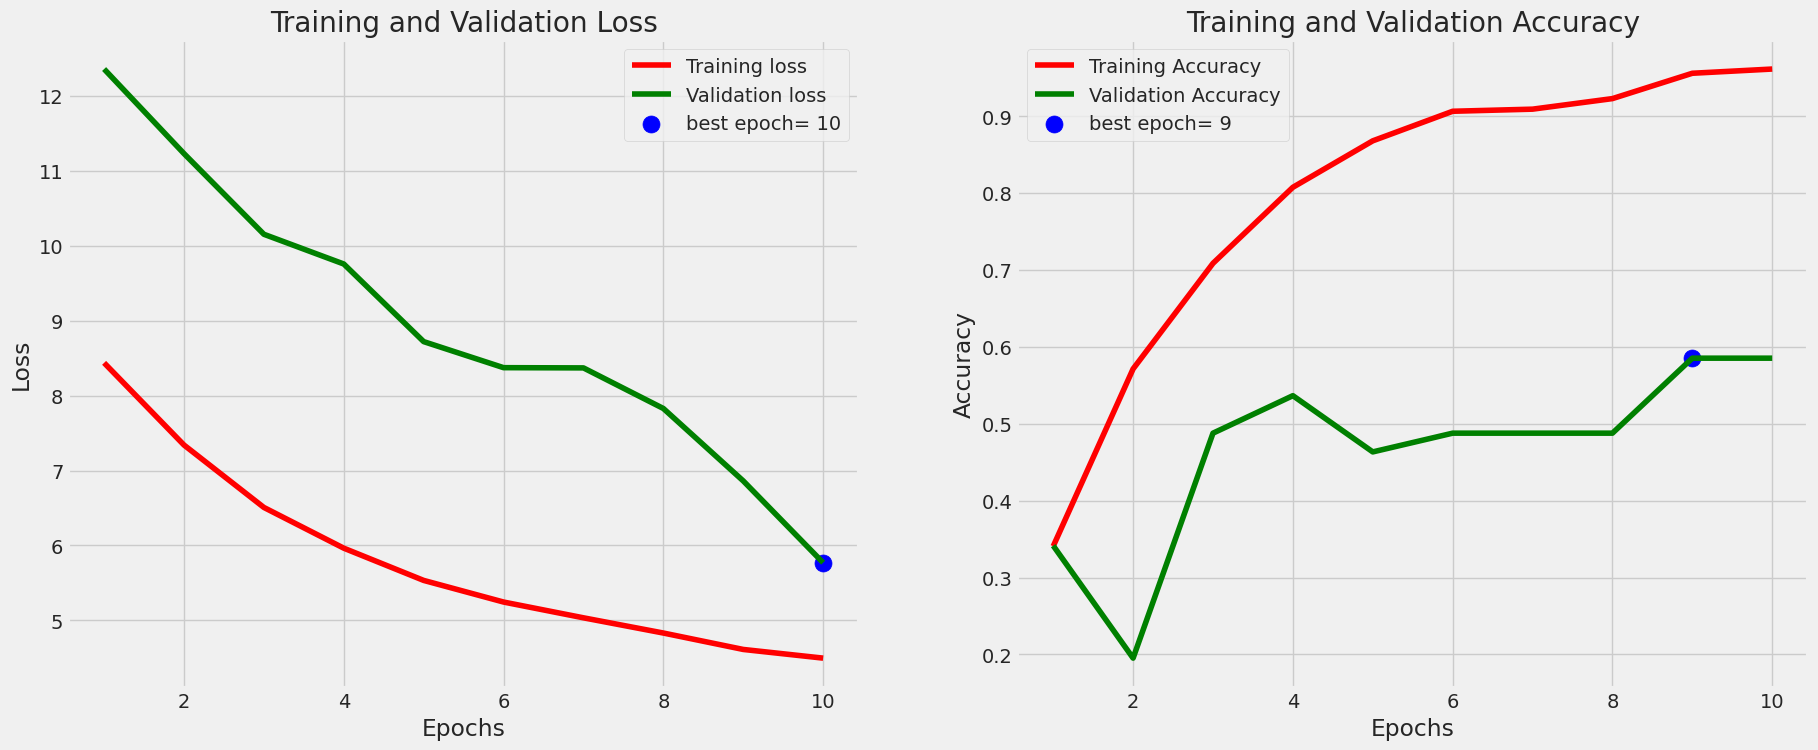

1/1 [==============================] - 1s 824ms/step - loss: 6.1270 - accuracy: 0.6200
accuracy on the test set is 62.00 %



In [16]:
tr_plot(history,0)
save_dir=r'./'
subject='plants'
acc=model.evaluate( test_gen, batch_size=test_batch_size, verbose=1, steps=test_steps, return_dict=False)[1]*100
msg=f'accuracy on the test set is {acc:5.2f} %'
print_in_color(msg, (0,255,0),(55,65,80))
save_id=str (model_name +  '-' + subject +'-'+ str(acc)[:str(acc).rfind('.')+3] + '.h5')
save_loc=os.path.join(save_dir, save_id)
model.save(save_loc)

1/1 [==============================] - 4s 4s/step


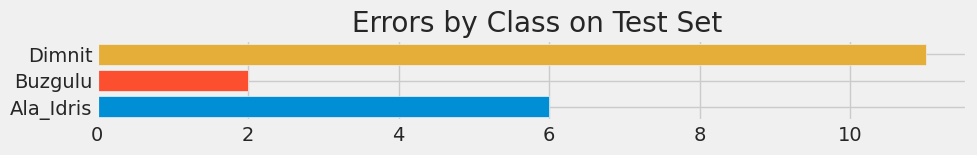

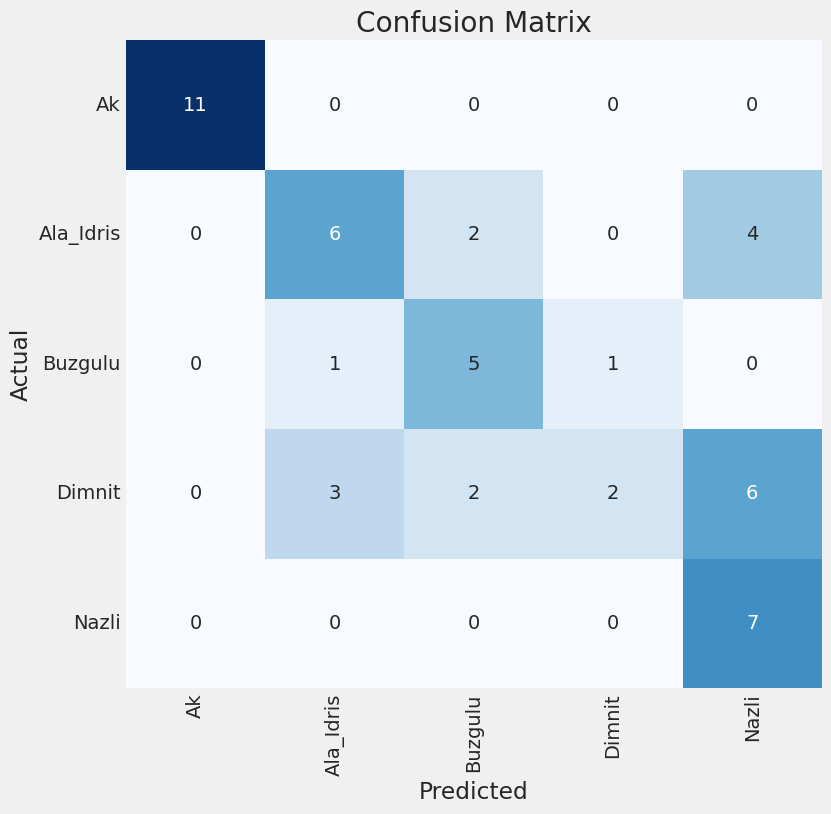

Classification Report:
----------------------
               precision    recall  f1-score   support

          Ak       1.00      1.00      1.00        11
   Ala_Idris       0.60      0.50      0.55        12
     Buzgulu       0.56      0.71      0.63         7
      Dimnit       0.67      0.15      0.25        13
       Nazli       0.41      1.00      0.58         7

    accuracy                           0.62        50
   macro avg       0.65      0.67      0.60        50
weighted avg       0.67      0.62      0.59        50



In [17]:
print_code=0
preds=model.predict(test_gen) 
print_info( test_gen, preds, print_code, save_dir, subject )